In [2]:
import os
import ROOT
from ROOT import gStyle
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)
            
def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(histogram_info[histogram_name][0],histogram_info[histogram_name][1],data)
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][2])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)

    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        #print("m range = ",ratio.GetBinCenter(i),"SF = ",round(ratio.GetBinContent(i),3),)
        if ratio.GetBinContent(i)>0 or i==1:
            x_values.append(ratio.GetBinLowEdge(i))
            y_values.append(round(ratio.GetBinContent(i),3))
            y_uncern.append(ratio.GetBinError(i))
        else : 
            break
    
    return np.array(x_values),np.array(y_values),np.array(y_uncern)

Welcome to JupyROOT 6.26/04


In [62]:
path_CRa = "/home/diegol/HEP/VBF-Analysis/MuMu/Plots/MasterCR/CRa"
path_CRb = "/home/diegol/HEP/VBF-Analysis/MuMu/Plots/MasterCR/CRb"
path_CRc = "/home/diegol/HEP/VBF-Analysis/MuMu/Plots/MasterCR/CRc"
signal = "Zmumu_MG"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

CRa_axis,CRa_y,CRa_error=ratio_subtracted_plot(path_to_samples=path_CRa,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRb_axis,CRb_y,CRb_error=ratio_subtracted_plot(path_to_samples=path_CRb,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRc_axis,CRc_y,CRc_error=ratio_subtracted_plot(path_to_samples=path_CRc,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)

0.0
5000.0
0.0
5000.0
0.0
5000.0


In [63]:
CRa_axis

array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 2000., 2500.,
       3000., 4000.])

In [64]:
from scipy.optimize import curve_fit

def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c

def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))


CRa_fit, CRa_cov = curve_fit(parabolic_shape, CRa_axis[1:], CRa_y[1:],sigma=CRa_error[1:])
CRb_fit, CRb_cov = curve_fit(parabolic_shape, CRb_axis[1:], CRb_y[1:],sigma=CRb_error[1:])
CRc_fit, CRc_cov = curve_fit(parabolic_shape, CRc_axis[1:], CRc_y[1:],sigma=CRc_error[1:])

In [65]:
def model_uncern(covariance_matrix,x):
    sigma_a = np.sqrt(covariance_matrix[0][0])
    sigma_b = np.sqrt(covariance_matrix[1][1])
    sigma_c = np.sqrt(covariance_matrix[2][2])
    
    cov_ab = covariance_matrix[0][1]
    cov_ac = covariance_matrix[0][2]
    cov_bc = covariance_matrix[1][2]
    
    diagonal_term = sigma_a**2*x**4 + sigma_b**2*x**2 + sigma_c**2
    no_diagonal_term = 2*cov_ab*x**3 + 2*cov_ac*x**2 + 2*cov_bc*x
    
    return np.sqrt(diagonal_term+no_diagonal_term)

model_uncer = np.vectorize(model_uncern)
parabolic_shape = np.vectorize(parabolic_shape)

In [66]:
x=np.linspace(250,5000,100)
CRa_predy,CRa_prederror = parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]),model_uncern(CRa_cov,x)
CRb_predy,CRb_prederror = parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2]),model_uncern(CRb_cov,x)
CRc_predy,CRc_prederror = parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2]),model_uncern(CRc_cov,x)

SR_y = CRa_predy*CRc_predy/CRb_predy
SR_error = SR_y*np.sqrt((CRa_prederror/CRa_predy)**2+(CRb_prederror/CRb_predy)**2+(CRc_prederror/CRc_predy)**2)



(-0.1, 1.5)

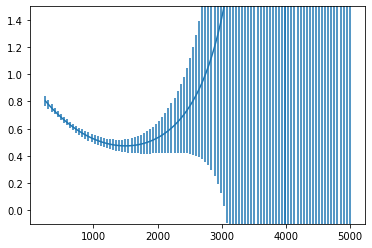

In [67]:
plt.errorbar(x,SR_y,yerr=SR_error)
plt.ylim([-.1,1.5])

In [45]:
SR_error

array([0.02678975, 0.02407891, 0.02191093, 0.02036801, 0.01949593,
       0.01927615, 0.01961964, 0.02039064, 0.0214431 , 0.02264785,
       0.02390381, 0.02513827, 0.02630288, 0.0273689 , 0.02832299,
       0.02916394, 0.02989989, 0.030546  , 0.03112236, 0.03165195,
       0.03215883, 0.03266641, 0.03319605, 0.03376597, 0.03439061,
       0.03508042, 0.03584205, 0.03667887, 0.03759168, 0.03857946,
       0.03964012, 0.0407711 , 0.04196986, 0.04323417, 0.04456233,
       0.04595319, 0.04740615, 0.04892113, 0.05049842, 0.05213862,
       0.05384254, 0.0556111 , 0.0574453 , 0.05934613, 0.06131454,
       0.06335143, 0.06545766, 0.06763397, 0.06988107, 0.07219959,
       0.07459008, 0.07705305, 0.07958897, 0.08219825, 0.08488129,
       0.08763845, 0.09047006, 0.09337645, 0.09635792, 0.09941476,
       0.10254727, 0.1057557 , 0.10904033, 0.11240142, 0.11583923,
       0.119354  , 0.12294598, 0.12661541, 0.13036252, 0.13418755,
       0.13809073, 0.14207226, 0.14613238, 0.15027129, 0.15448

array([0.01617711, 0.01458531, 0.01321937, 0.01210034, 0.0112462 ,
       0.0106659 , 0.0103534 , 0.01028495, 0.01042208, 0.01071894,
       0.01113013, 0.011616  , 0.01214486, 0.01269304, 0.01324387,
       0.01378654, 0.0143149 , 0.0148266 , 0.01532244, 0.01580581,
       0.01628238, 0.01675977, 0.01724728, 0.01775566, 0.0182968 ,
       0.01888341, 0.01952866, 0.02024575, 0.02104751, 0.02194602,
       0.02295223, 0.02407575, 0.02532463, 0.02670541, 0.02822308,
       0.02988126, 0.03168236, 0.03362777, 0.03571805, 0.03795317,
       0.04033261, 0.04285553, 0.04552088, 0.04832747, 0.05127408,
       0.05435944, 0.05758233, 0.06094155, 0.06443597, 0.06806453,
       0.07182622, 0.07572014, 0.07974541, 0.08390125, 0.08818694,
       0.0926018 , 0.09714524, 0.10181668, 0.10661561, 0.11154157,
       0.11659411, 0.12177286, 0.12707743, 0.1325075 , 0.13806277,
       0.14374295, 0.14954777, 0.15547701, 0.16153044, 0.16770786,
       0.17400908, 0.18043392, 0.18698222, 0.19365384, 0.20044